# How to Segment Buildings on Drone Imagery with Fast.ai & Cloud-Native GeoData Tools

## An Interactive Intro to Geospatial Deep Learning on Google Colab 




# Pre-Processing

**Note that the preprocessing section is possible to be done on CPU runtime:**

Change in menu: Runtime > Change runtime type > Hardware Accelerator = None

## Install all the geo things

`Pip install` the required geodata processing packages we'll be using of, test that their import to Colab works, and create our output data directories.

In [0]:
# to mount and transfer to GDrive: uncomment and run this and the next cell, follow instructions to auhorize access to your GDrive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!add-apt-repository ppa:ubuntugis/ppa
!apt-get update
!apt-get install python-numpy gdal-bin libgdal-dev
!apt install python3-rtree

!pip install geopandas

In [0]:
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
from pathlib import Path
import os

data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

ModuleNotFoundError: ignored

In [0]:

from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import numpy as np
def plot_building_mask(input_image, mask_image,   
                  figsize=(8,8), plot_name='',
                  add_title=False, poly_face_color='orange', 
                  poly_edge_color='red', poly_nofill_color='blue', cmap='bwr'):
    
    fig, (ax0, ax2) = plt.subplots(1, 2, 
                                        figsize=(2*figsize[0], figsize[1]))
    
    if add_title:
        suptitle = fig.suptitle(plot_name.split('/')[-1], fontsize='large')

    ax0.imshow(input_image)
    ax0.set_title('Input Image') 
   
    # mask
    ax2.imshow(mask_image, cmap=cmap)
    # truth polygons?
    #if len(patches) > 0:
    #    ax1.add_collection(p1)
    ax2.set_title('Ground Truth Building Mask')    
          
    #plt.axis('off')
    plt.tight_layout()
    if add_title:
        suptitle.set_y(0.95)
        fig.subplots_adjust(top=0.96)
    plt.show()
 
    if len(plot_name) > 0:
        plt.savefig(plot_name)
    
    return

In [0]:
from osgeo import gdal, ogr
from PIL import Image
import numpy as np
import os
import tqdm


def create_poly_mask(rasterSrc, vectorSrc, npDistFileName='', 
							noDataValue=0, burn_values=1):

    '''
    Create polygon mask for rasterSrc,
    Similar to labeltools/createNPPixArray() in spacenet utilities
    '''
    
    ## open source vector file that truth data
    source_ds = ogr.Open(vectorSrc)
    source_layer = source_ds.GetLayer()

    ## extract data from src Raster File to be emulated
    ## open raster file that is to be emulated
    srcRas_ds = gdal.Open(rasterSrc)
    cols = srcRas_ds.RasterXSize
    rows = srcRas_ds.RasterYSize

    if npDistFileName == '':
      dstPath = ".tmp.tiff"
    else:
      dstPath = npDistFileName

    ## create First raster memory layer, units are pixels
    # Change output to geotiff instead of memory 
    memdrv = gdal.GetDriverByName('GTiff') 
    dst_ds = memdrv.Create(dstPath, cols, rows, 1, gdal.GDT_Byte, 
                options=['COMPRESS=LZW'])
    dst_ds.SetGeoTransform(srcRas_ds.GetGeoTransform())
    dst_ds.SetProjection(srcRas_ds.GetProjection())
    band = dst_ds.GetRasterBand(1)
    band.SetNoDataValue(noDataValue)    
    gdal.RasterizeLayer(dst_ds, [1], source_layer, burn_values=[burn_values])
    dst_ds = 0

    mask_image = Image.open(dstPath)
    mask_image = np.array(mask_image)

    if npDistFileName == '':
      os.remove(dstPath)
      
    return mask_image

In [0]:
def build_labels(src_raster_dir, src_vector_dir, dst_dir):
	
    os.makedirs(dst_dir, exist_ok=True)

    file_count = len([f for f in os.walk(src_vector_dir).__next__()[2] if f[-8:] == ".geojson"])

    print("[INFO] Found {} geojson files. Preparing building mask images...".format(file_count))

    for idx in tqdm.tqdm(range(1, file_count + 1)): # 3 bc doesn't exist image1 or image2

      src_raster_filename = "3band_AOI_1_RIO_img{}.tif".format(idx)
      src_vector_filename = "Geo_AOI_1_RIO_img{}.geojson".format(idx)
      src_raster_path = os.path.join(src_raster_dir, src_raster_filename)
      src_vector_path = os.path.join(src_vector_dir, src_vector_filename)
      dst_path = os.path.join(dst_dir, src_raster_filename)

      if os.path.isfile(src_raster_path):
        create_poly_mask(
          src_raster_path, src_vector_path, npDistFileName=dst_path, 
          noDataValue=0, burn_values=1
        )

In [0]:
def show(idx):
  from PIL import Image
  # Modify the the paths based on your raster and geojson data location.   
  src_raster_filename = "3band_AOI_1_RIO_img{}.tif".format(idx)
  src_mask_filename = "3band_AOI_1_RIO_img{}.tif".format(idx)

  raster_path, mask_path = os.path.join(src_raster_dir, src_raster_filename), os.path.join(dst_dir, src_mask_filename)

  # Create building mask image
  mask_image = Image.open(mask_path)

  # Get input raster as a numpy array
  input_image = Image.open(raster_path)
  input_image = np.array(input_image)
  
  #input_image = np.transpose(np.array(input_image.ReadAsArray()), (1,2,0))
  #input_image = input_image / input_image.max()

  plot_building_mask(input_image, mask_image)

In [0]:
base_path = "drive/My Drive/datasets/RIO/"
src_raster_dir = base_path + "3band/"
src_vector_dir = base_path + "vectordata/geojson/"
dst_dir = base_path + "masks_2/"


# Generate masks

In [0]:
build_labels(src_raster_dir, src_vector_dir, dst_dir)


  1%|          | 78/6940 [00:06<09:12, 12.43it/s]

  1%|          | 80/6940 [00:06<09:06, 12.56it/s]

  1%|          | 82/6940 [00:06<09:45, 11.72it/s]

  1%|          | 84/6940 [00:07<09:55, 11.52it/s]

  1%|          | 86/6940 [00:07<09:49, 11.64it/s]

  1%|▏         | 88/6940 [00:07<09:56, 11.49it/s]

  1%|▏         | 90/6940 [00:07<09:48, 11.63it/s]

  1%|▏         | 92/6940 [00:07<10:08, 11.25it/s]

  1%|▏         | 94/6940 [00:07<09:56, 11.47it/s]

  1%|▏         | 96/6940 [00:08<10:01, 11.38it/s]

  1%|▏         | 98/6940 [00:08<09:48, 11.63it/s]

  1%|▏         | 100/6940 [00:08<09:40, 11.79it/s]

  1%|▏         | 102/6940 [00:08<10:16, 11.09it/s]

  1%|▏         | 104/6940 [00:08<10:06, 11.27it/s]

  2%|▏         | 106/6940 [00:09<10:01, 11.36it/s]

  2%|▏         | 108/6940 [00:09<09:51, 11.54it/s]

  2%|▏         | 110/6940 [00:09<09:41, 11.74it/s]

  2%|▏         | 112/6940 [00:09<10:07, 11.24it/s]

  2%|▏         | 114/6940 [00:09<09:53, 11.51it/s]

  2%|▏         | 116/69

## Preview and load imagery and labels


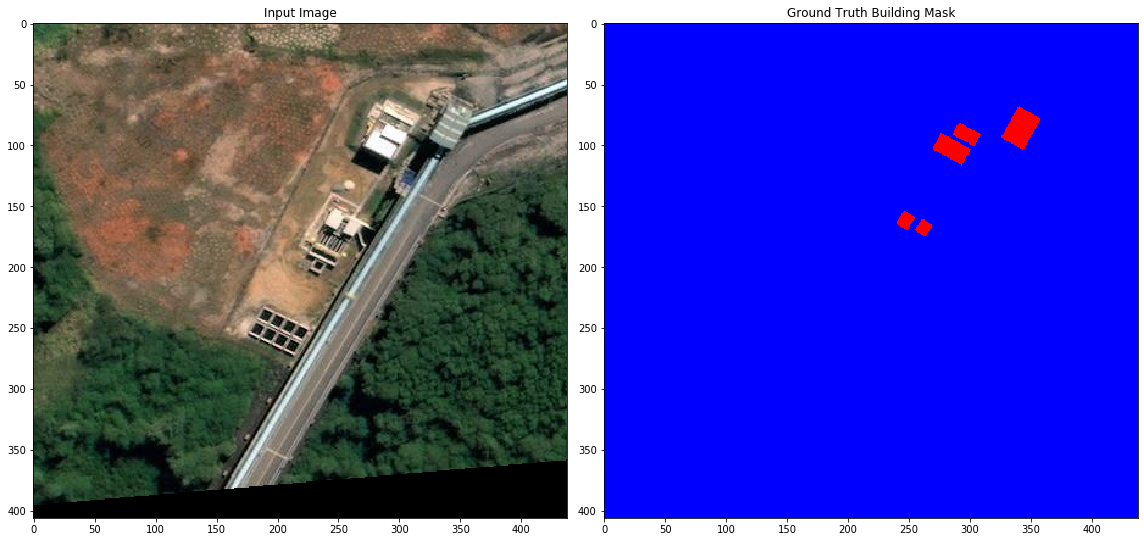

In [0]:
show(12)

In [0]:
show(362)

# Acknowledgments and Special Thanks to

- [World Bank GFDRR](https://www.gfdrr.org/en)'s Open Data for Resilience
Initiative ([OpenDRI](https://opendri.org/)) for consultation projects which have inspired & informed.
- [Zanzibar Mapping Initiative](http://www.zanzibarmapping.com/), [OpenAerialMap](https://openaerialmap.org/), State University of Zanzibar ([SUZA](https://www.suza.ac.tz/)), Govt of Zanzibar's Commission for Lands, & [WeRobotics](https://werobotics.org/) for the [2018 Open AI Tanzania Building Footprint Segmentation Challenge](https://competitions.codalab.org/competitions/20100).
- [Fast.ai team](https://www.fast.ai/about/), [contributors](https://github.com/fastai/fastai/graphs/contributors), & [community](https://forums.fast.ai/) for both "making neural nets uncool again" and pushing its cutting edge (very cool).
- [SpaceNet](https://spacenet.ai/) & [Cosmiq Works](http://www.cosmiqworks.org/) for the open challenges, datasets, knowledge-sharing, [Solaris geoML toolkit](https://github.com/CosmiQ/solaris), & more that advance geospatial machine learning.
- Contributors to [COG](https://www.cogeo.org/), [STAC](https://stacspec.org/), and more initiatives advancing the [cloud native geospatial](https://medium.com/planet-stories/tagged/cloud-native-geospatial) ecosystem.
- [Free & open source](https://en.wikipedia.org/wiki/Free_and_open-source_software) creators & collaborators everywhere for the invaluable public goods you provide.

# Notebook Changelog

## v1 (2019-07-25):
-------
New: 1st public release

Changed: n/a

Fixed: n/a